In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### Bivariate Normal Data Generation

In [3]:
MU = {
    1: [1,1],
    2: [4,3],
    3: [2,6],
    4: [7,4]
}

COV = {
    1: np.eye(2)*0.05,
    2: np.eye(2)*0.05,
    3: np.eye(2)*0.05,
    4: np.eye(2)*0.05
}

N_SAMPLERS = 4
SAMPLERS = {}
for idx in range(1, N_SAMPLERS+1, 1):
    SAMPLERS[idx] = N(MU[idx], COV[idx])

In [4]:
n = 1000
X_TRAIN, Y_TRAIN = {}, {}
X_TEST, Y_TEST = {}, {}

for cls in SAMPLERS:
    X_TRAIN[cls] = SAMPLERS[cls].sample(n)
    Y_TRAIN[cls] = np.array([cls]*n)
    X_TEST[cls] = SAMPLERS[cls].sample(n)
    Y_TEST[cls] = np.array([cls]*n)

# Dataset
def cls_to_dset(idxs, X, Y):
    x, y = [], []
    for idx in idxs:
        x.extend(X[idx])
        y.extend(Y[idx])
    x = np.array(x)
    y = np.array(y)
    return list(zip(x, y)), x, y

IND_CLS = [1, 2, 3]
OOD_CLS = [4]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)


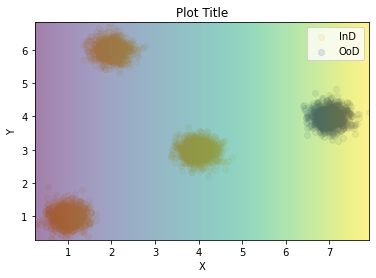

In [5]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.10)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.10)
xi = np.linspace(0, 8, 100, endpoint=True)
yi = np.linspace(0, 8, 100, endpoint=True)
# xy_pos = list(product(x_pos, y_pos))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
nbins=300
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
plt.pcolormesh(xi, yi, xi, shading='auto', alpha=0.50)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### Naive Classifier Training

In [17]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configguration
max_epoch = 64
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch)

  5%|▍         | 3/64 [00:00<00:05, 11.14it/s]

Epoch  # 1 | Tri loss: 0.9567                     | Tri accuracy: 0.5866
Epoch  # 1 | Val loss: 0.8274                     | Val accuracy: 0.6684


 20%|██        | 13/64 [00:00<00:03, 16.88it/s]

Epoch  # 11 | Tri loss: 0.0096                     | Tri accuracy: 1.0
Epoch  # 11 | Val loss: 0.0076                     | Val accuracy: 1.0


 39%|███▉      | 25/64 [00:01<00:01, 21.57it/s]

Epoch  # 21 | Tri loss: 0.0009                     | Tri accuracy: 1.0
Epoch  # 21 | Val loss: 0.0008                     | Val accuracy: 1.0


 53%|█████▎    | 34/64 [00:01<00:01, 22.78it/s]

Epoch  # 31 | Tri loss: 0.0003                     | Tri accuracy: 1.0
Epoch  # 31 | Val loss: 0.0003                     | Val accuracy: 1.0


 67%|██████▋   | 43/64 [00:02<00:00, 21.76it/s]

Epoch  # 41 | Tri loss: 0.0002                     | Tri accuracy: 1.0
Epoch  # 41 | Val loss: 0.0002                     | Val accuracy: 1.0


 81%|████████▏ | 52/64 [00:02<00:00, 18.75it/s]

Epoch  # 51 | Tri loss: 0.0001                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0001                     | Val accuracy: 1.0


100%|██████████| 64/64 [00:03<00:00, 19.00it/s]

Epoch  # 61 | Tri loss: 0.0001                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.0001                     | Val accuracy: 1.0


#### Plot

torch.Size([2500, 3])


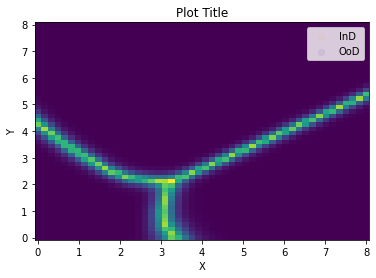

In [18]:
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
nbins=50
# xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)

# zi = torch.softmax(D(torch.tensor(np.vstack([xi.flatten(), yi.flatten()]).T, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)), shading='auto', alpha=1)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### WOOD Training

In [41]:
from simulation import *
D_WOOD = DSIM()
# OOD data preparation
n_ood = 64
ood_bsz = 64
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 64
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=2)

OOD Batch Shape: torch.Size([64, 2])


  2%|▏         | 1/64 [00:07<07:49,  7.46s/it]

Epoch  # 1 | Tri loss: 0.9526                     | Tri accuracy: 0.5072
Epoch  # 1 | Val loss: 0.9566                     | Val accuracy: 0.4123


  5%|▍         | 3/64 [00:22<07:42,  7.58s/it]

Epoch  # 3 | Tri loss: 0.8406                     | Tri accuracy: 0.7234
Epoch  # 3 | Val loss: 0.8508                     | Val accuracy: 0.7831


  8%|▊         | 5/64 [00:35<06:50,  6.96s/it]

Epoch  # 5 | Tri loss: 0.7308                     | Tri accuracy: 0.8139
Epoch  # 5 | Val loss: 0.7403                     | Val accuracy: 0.8994


 11%|█         | 7/64 [00:48<06:19,  6.66s/it]

Epoch  # 7 | Tri loss: 0.6223                     | Tri accuracy: 0.9246
Epoch  # 7 | Val loss: 0.6325                     | Val accuracy: 0.9321


 14%|█▍        | 9/64 [01:01<05:56,  6.49s/it]

Epoch  # 9 | Tri loss: 0.5169                     | Tri accuracy: 0.9303
Epoch  # 9 | Val loss: 0.5287                     | Val accuracy: 0.9688


 17%|█▋        | 11/64 [01:14<05:43,  6.49s/it]

Epoch  # 11 | Tri loss: 0.4345                     | Tri accuracy: 0.9277
Epoch  # 11 | Val loss: 0.4603                     | Val accuracy: 0.9288


 20%|██        | 13/64 [01:26<05:25,  6.38s/it]

Epoch  # 13 | Tri loss: 0.3806                     | Tri accuracy: 0.9017
Epoch  # 13 | Val loss: 0.4167                     | Val accuracy: 0.9062


 23%|██▎       | 15/64 [01:39<05:10,  6.34s/it]

Epoch  # 15 | Tri loss: 0.3458                     | Tri accuracy: 0.9393
Epoch  # 15 | Val loss: 0.3875                     | Val accuracy: 0.9046


 27%|██▋       | 17/64 [01:52<04:55,  6.29s/it]

Epoch  # 17 | Tri loss: 0.3349                     | Tri accuracy: 0.9569
Epoch  # 17 | Val loss: 0.3712                     | Val accuracy: 0.9779


 30%|██▉       | 19/64 [02:04<04:41,  6.24s/it]

Epoch  # 19 | Tri loss: 0.3238                     | Tri accuracy: 0.979
Epoch  # 19 | Val loss: 0.3593                     | Val accuracy: 0.9921


 33%|███▎      | 21/64 [02:16<04:26,  6.21s/it]

Epoch  # 21 | Tri loss: 0.3241                     | Tri accuracy: 0.9847
Epoch  # 21 | Val loss: 0.3615                     | Val accuracy: 0.9897


 36%|███▌      | 23/64 [02:29<04:14,  6.22s/it]

Epoch  # 23 | Tri loss: 0.3195                     | Tri accuracy: 0.9874
Epoch  # 23 | Val loss: 0.3605                     | Val accuracy: 0.9911


 39%|███▉      | 25/64 [02:41<04:02,  6.21s/it]

Epoch  # 25 | Tri loss: 0.3156                     | Tri accuracy: 0.9912
Epoch  # 25 | Val loss: 0.3525                     | Val accuracy: 0.9953


 42%|████▏     | 27/64 [02:54<03:52,  6.28s/it]

Epoch  # 27 | Tri loss: 0.3142                     | Tri accuracy: 0.9937
Epoch  # 27 | Val loss: 0.3541                     | Val accuracy: 0.9948


 45%|████▌     | 29/64 [03:06<03:37,  6.22s/it]

Epoch  # 29 | Tri loss: 0.312                     | Tri accuracy: 0.9951
Epoch  # 29 | Val loss: 0.3552                     | Val accuracy: 0.9974


 48%|████▊     | 31/64 [03:19<03:26,  6.25s/it]

Epoch  # 31 | Tri loss: 0.3149                     | Tri accuracy: 0.9833
Epoch  # 31 | Val loss: 0.3425                     | Val accuracy: 0.999


 52%|█████▏    | 33/64 [03:31<03:12,  6.20s/it]

Epoch  # 33 | Tri loss: 0.3066                     | Tri accuracy: 0.9967
Epoch  # 33 | Val loss: 0.343                     | Val accuracy: 0.9993


 55%|█████▍    | 35/64 [03:43<03:00,  6.22s/it]

Epoch  # 35 | Tri loss: 0.3066                     | Tri accuracy: 0.9969
Epoch  # 35 | Val loss: 0.3448                     | Val accuracy: 0.9993


 58%|█████▊    | 37/64 [03:56<02:47,  6.20s/it]

Epoch  # 37 | Tri loss: 0.3052                     | Tri accuracy: 0.998
Epoch  # 37 | Val loss: 0.3392                     | Val accuracy: 0.9992


 61%|██████    | 39/64 [04:08<02:34,  6.19s/it]

Epoch  # 39 | Tri loss: 0.2979                     | Tri accuracy: 0.998
Epoch  # 39 | Val loss: 0.3345                     | Val accuracy: 0.9993


 64%|██████▍   | 41/64 [04:21<02:22,  6.20s/it]

Epoch  # 41 | Tri loss: 0.2963                     | Tri accuracy: 0.9993
Epoch  # 41 | Val loss: 0.3312                     | Val accuracy: 0.9993


 67%|██████▋   | 43/64 [04:33<02:10,  6.23s/it]

Epoch  # 43 | Tri loss: 0.297                     | Tri accuracy: 0.9993
Epoch  # 43 | Val loss: 0.3334                     | Val accuracy: 0.9993


 70%|███████   | 45/64 [04:46<01:58,  6.22s/it]

Epoch  # 45 | Tri loss: 0.2919                     | Tri accuracy: 0.9993
Epoch  # 45 | Val loss: 0.3312                     | Val accuracy: 0.9993


 73%|███████▎  | 47/64 [04:58<01:45,  6.21s/it]

Epoch  # 47 | Tri loss: 0.2882                     | Tri accuracy: 0.9993
Epoch  # 47 | Val loss: 0.3313                     | Val accuracy: 0.9993


 77%|███████▋  | 49/64 [05:10<01:33,  6.20s/it]

Epoch  # 49 | Tri loss: 0.2845                     | Tri accuracy: 0.9997
Epoch  # 49 | Val loss: 0.3274                     | Val accuracy: 0.9997


 80%|███████▉  | 51/64 [05:23<01:20,  6.19s/it]

Epoch  # 51 | Tri loss: 0.283                     | Tri accuracy: 0.9997
Epoch  # 51 | Val loss: 0.3205                     | Val accuracy: 0.9997


 83%|████████▎ | 53/64 [05:36<01:10,  6.42s/it]

Epoch  # 53 | Tri loss: 0.2812                     | Tri accuracy: 0.9997
Epoch  # 53 | Val loss: 0.323                     | Val accuracy: 0.9997


 86%|████████▌ | 55/64 [05:49<00:58,  6.45s/it]

Epoch  # 55 | Tri loss: 0.2802                     | Tri accuracy: 0.9997
Epoch  # 55 | Val loss: 0.3167                     | Val accuracy: 0.9997


 89%|████████▉ | 57/64 [06:02<00:45,  6.44s/it]

Epoch  # 57 | Tri loss: 0.2749                     | Tri accuracy: 0.9997
Epoch  # 57 | Val loss: 0.3146                     | Val accuracy: 0.9997


 92%|█████████▏| 59/64 [06:15<00:31,  6.39s/it]

Epoch  # 59 | Tri loss: 0.2703                     | Tri accuracy: 1.0
Epoch  # 59 | Val loss: 0.3134                     | Val accuracy: 0.9995


 95%|█████████▌| 61/64 [06:28<00:19,  6.57s/it]

Epoch  # 61 | Tri loss: 0.2711                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.3061                     | Val accuracy: 1.0


 98%|█████████▊| 63/64 [06:42<00:06,  6.88s/it]

Epoch  # 63 | Tri loss: 0.2635                     | Tri accuracy: 1.0
Epoch  # 63 | Val loss: 0.3015                     | Val accuracy: 0.9997


100%|██████████| 64/64 [06:49<00:00,  6.40s/it]


torch.Size([2500, 3])


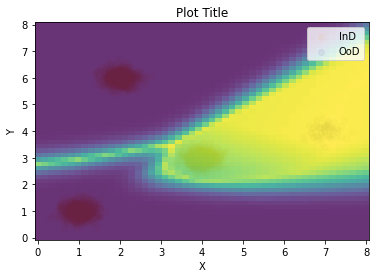

In [42]:
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

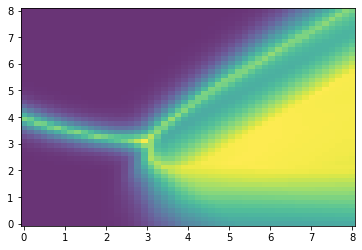

In [26]:
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)

### OOD GAN Training

In [46]:
from simulation import *
D_GAN = DSIM()
G_GAN = GSIM()
# OOD data preparation
n_ood = 64
ood_bsz = 64
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 64
lr = 1e-3
w_ce, w_wass = 1, 0.1
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, \
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=2)

[autoreload of simulation failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Library/Frameworks/Python.framewor

OOD Batch Shape: torch.Size([64, 2])


  8%|▊         | 1/12 [00:01<00:20,  1.86s/it]

Step: 0    | D:  1.1568 | CE:  1.1541 | W_OoD:  1.0786 | W_z:  1.0023 | G:  0.0372 | W_z:  0.9896


 25%|██▌       | 3/12 [00:05<00:16,  1.84s/it]

Step: 2    | D:  1.1699 | CE:  1.1679 | W_OoD:  1.0340 | W_z:  0.9794 | G:  0.0375 | W_z:  0.9819


 42%|████▏     | 5/12 [00:09<00:12,  1.82s/it]

Step: 4    | D:  1.1019 | CE:  1.1004 | W_OoD:  1.0225 | W_z:  0.9800 | G:  0.0377 | W_z:  0.9761


 58%|█████▊    | 7/12 [00:12<00:09,  1.81s/it]

Step: 6    | D:  1.0789 | CE:  1.0768 | W_OoD:  1.0295 | W_z:  0.9710 | G:  0.0382 | W_z:  0.9617


 75%|███████▌  | 9/12 [00:16<00:05,  1.80s/it]

Step: 8    | D:  1.0678 | CE:  1.0666 | W_OoD:  0.9853 | W_z:  0.9542 | G:  0.0385 | W_z:  0.9550


 92%|█████████▏| 11/12 [00:19<00:01,  1.80s/it]

Step: 10   | D:  1.0666 | CE:  1.0652 | W_OoD:  0.9889 | W_z:  0.9527 | G:  0.0387 | W_z:  0.9483


100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Epoch  # 1 | Val accuracy: 0.6643


  8%|▊         | 1/12 [00:01<00:19,  1.79s/it]

Step: 0    | D:  1.0394 | CE:  1.0373 | W_OoD:  0.9974 | W_z:  0.9426 | G:  0.0390 | W_z:  0.9407


 25%|██▌       | 3/12 [00:05<00:16,  1.79s/it]

Step: 2    | D:  1.0266 | CE:  1.0255 | W_OoD:  0.9708 | W_z:  0.9434 | G:  0.0389 | W_z:  0.9430


 42%|████▏     | 5/12 [00:08<00:12,  1.78s/it]

Step: 4    | D:  1.0276 | CE:  1.0269 | W_OoD:  0.9580 | W_z:  0.9409 | G:  0.0391 | W_z:  0.9380


 58%|█████▊    | 7/12 [00:12<00:08,  1.79s/it]

Step: 6    | D:  1.0184 | CE:  1.0171 | W_OoD:  0.9706 | W_z:  0.9369 | G:  0.0391 | W_z:  0.9380


 75%|███████▌  | 9/12 [00:16<00:05,  1.79s/it]

Step: 8    | D:  0.9977 | CE:  0.9969 | W_OoD:  0.9591 | W_z:  0.9373 | G:  0.0392 | W_z:  0.9369


 92%|█████████▏| 11/12 [00:19<00:01,  1.78s/it]

Step: 10   | D:  1.0007 | CE:  1.0000 | W_OoD:  0.9562 | W_z:  0.9381 | G:  0.0391 | W_z:  0.9388


  8%|▊         | 1/12 [00:01<00:19,  1.79s/it]

Step: 0    | D:  0.9976 | CE:  0.9967 | W_OoD:  0.9612 | W_z:  0.9384 | G:  0.0392 | W_z:  0.9377


 25%|██▌       | 3/12 [00:05<00:16,  1.78s/it]

Step: 2    | D:  0.9667 | CE:  0.9662 | W_OoD:  0.9466 | W_z:  0.9361 | G:  0.0392 | W_z:  0.9372


 42%|████▏     | 5/12 [00:08<00:12,  1.76s/it]

Step: 4    | D:  0.9759 | CE:  0.9755 | W_OoD:  0.9493 | W_z:  0.9373 | G:  0.0392 | W_z:  0.9368


 58%|█████▊    | 7/12 [00:12<00:08,  1.76s/it]

Step: 6    | D:  0.9459 | CE:  0.9456 | W_OoD:  0.9468 | W_z:  0.9371 | G:  0.0392 | W_z:  0.9370


 75%|███████▌  | 9/12 [00:15<00:05,  1.78s/it]

Step: 8    | D:  0.9461 | CE:  0.9455 | W_OoD:  0.9512 | W_z:  0.9365 | G:  0.0392 | W_z:  0.9369


 92%|█████████▏| 11/12 [00:19<00:01,  1.76s/it]

Step: 10   | D:  0.9499 | CE:  0.9494 | W_OoD:  0.9508 | W_z:  0.9370 | G:  0.0392 | W_z:  0.9359


100%|██████████| 12/12 [00:21<00:00,  1.76s/it]


Epoch  # 3 | Val accuracy: 0.6532


  8%|▊         | 1/12 [00:01<00:18,  1.73s/it]

Step: 0    | D:  0.9358 | CE:  0.9352 | W_OoD:  0.9532 | W_z:  0.9371 | G:  0.0392 | W_z:  0.9373


 25%|██▌       | 3/12 [00:05<00:15,  1.76s/it]

Step: 2    | D:  0.9395 | CE:  0.9391 | W_OoD:  0.9458 | W_z:  0.9364 | G:  0.0392 | W_z:  0.9362


 42%|████▏     | 5/12 [00:08<00:12,  1.75s/it]

Step: 4    | D:  0.9103 | CE:  0.9100 | W_OoD:  0.9450 | W_z:  0.9369 | G:  0.0392 | W_z:  0.9370


 58%|█████▊    | 7/12 [00:12<00:08,  1.73s/it]

Step: 6    | D:  0.8922 | CE:  0.8917 | W_OoD:  0.9510 | W_z:  0.9378 | G:  0.0392 | W_z:  0.9370


 75%|███████▌  | 9/12 [00:15<00:05,  1.78s/it]

Step: 8    | D:  0.9039 | CE:  0.9032 | W_OoD:  0.9538 | W_z:  0.9358 | G:  0.0392 | W_z:  0.9361


 92%|█████████▏| 11/12 [00:19<00:01,  1.82s/it]

Step: 10   | D:  0.9008 | CE:  0.9003 | W_OoD:  0.9503 | W_z:  0.9367 | G:  0.0392 | W_z:  0.9357


  8%|▊         | 1/12 [00:01<00:18,  1.70s/it]

Step: 0    | D:  0.8879 | CE:  0.8876 | W_OoD:  0.9428 | W_z:  0.9356 | G:  0.0392 | W_z:  0.9355


 25%|██▌       | 3/12 [00:05<00:15,  1.74s/it]

Step: 2    | D:  0.8628 | CE:  0.8624 | W_OoD:  0.9467 | W_z:  0.9363 | G:  0.0392 | W_z:  0.9362


 42%|████▏     | 5/12 [00:08<00:12,  1.73s/it]

Step: 4    | D:  0.8763 | CE:  0.8762 | W_OoD:  0.9381 | W_z:  0.9360 | G:  0.0392 | W_z:  0.9356


 58%|█████▊    | 7/12 [00:12<00:08,  1.72s/it]

Step: 6    | D:  0.8647 | CE:  0.8645 | W_OoD:  0.9413 | W_z:  0.9360 | G:  0.0392 | W_z:  0.9357


 75%|███████▌  | 9/12 [00:15<00:05,  1.73s/it]

Step: 8    | D:  0.8787 | CE:  0.8785 | W_OoD:  0.9422 | W_z:  0.9355 | G:  0.0393 | W_z:  0.9350


 92%|█████████▏| 11/12 [00:19<00:01,  1.72s/it]

Step: 10   | D:  0.8583 | CE:  0.8580 | W_OoD:  0.9428 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9352


100%|██████████| 12/12 [00:20<00:00,  1.72s/it]


Epoch  # 5 | Val accuracy: 0.662


  8%|▊         | 1/12 [00:01<00:18,  1.71s/it]

Step: 0    | D:  0.8438 | CE:  0.8436 | W_OoD:  0.9399 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9349


 25%|██▌       | 3/12 [00:05<00:15,  1.73s/it]

Step: 2    | D:  0.8056 | CE:  0.8055 | W_OoD:  0.9389 | W_z:  0.9356 | G:  0.0392 | W_z:  0.9354


 42%|████▏     | 5/12 [00:08<00:12,  1.72s/it]

Step: 4    | D:  0.8280 | CE:  0.8275 | W_OoD:  0.9484 | W_z:  0.9358 | G:  0.0392 | W_z:  0.9360


 58%|█████▊    | 7/12 [00:12<00:08,  1.71s/it]

Step: 6    | D:  0.8442 | CE:  0.8441 | W_OoD:  0.9386 | W_z:  0.9357 | G:  0.0393 | W_z:  0.9347


 75%|███████▌  | 9/12 [00:15<00:05,  1.72s/it]

Step: 8    | D:  0.8398 | CE:  0.8388 | W_OoD:  0.9618 | W_z:  0.9350 | G:  0.0392 | W_z:  0.9356


 92%|█████████▏| 11/12 [00:18<00:01,  1.73s/it]

Step: 10   | D:  0.8049 | CE:  0.8040 | W_OoD:  0.9595 | W_z:  0.9357 | G:  0.0392 | W_z:  0.9363


  8%|▊         | 1/12 [00:01<00:19,  1.74s/it]

Step: 0    | D:  0.7847 | CE:  0.7835 | W_OoD:  0.9663 | W_z:  0.9372 | G:  0.0392 | W_z:  0.9377


 25%|██▌       | 3/12 [00:05<00:15,  1.73s/it]

Step: 2    | D:  0.7989 | CE:  0.7982 | W_OoD:  0.9565 | W_z:  0.9386 | G:  0.0392 | W_z:  0.9369


 42%|████▏     | 5/12 [00:08<00:11,  1.71s/it]

Step: 4    | D:  0.8004 | CE:  0.8004 | W_OoD:  0.9384 | W_z:  0.9373 | G:  0.0391 | W_z:  0.9379


 58%|█████▊    | 7/12 [00:12<00:08,  1.74s/it]

Step: 6    | D:  0.7711 | CE:  0.7710 | W_OoD:  0.9385 | W_z:  0.9360 | G:  0.0392 | W_z:  0.9365


 75%|███████▌  | 9/12 [00:15<00:05,  1.78s/it]

Step: 8    | D:  0.7927 | CE:  0.7925 | W_OoD:  0.9400 | W_z:  0.9366 | G:  0.0392 | W_z:  0.9362


 92%|█████████▏| 11/12 [00:19<00:01,  1.78s/it]

Step: 10   | D:  0.8054 | CE:  0.8050 | W_OoD:  0.9467 | W_z:  0.9358 | G:  0.0393 | W_z:  0.9349


100%|██████████| 12/12 [00:21<00:00,  1.75s/it]


Epoch  # 7 | Val accuracy: 0.6564


  8%|▊         | 1/12 [00:01<00:19,  1.79s/it]

Step: 0    | D:  0.7500 | CE:  0.7495 | W_OoD:  0.9488 | W_z:  0.9359 | G:  0.0392 | W_z:  0.9352


 25%|██▌       | 3/12 [00:05<00:15,  1.74s/it]

Step: 2    | D:  0.7899 | CE:  0.7893 | W_OoD:  0.9529 | W_z:  0.9364 | G:  0.0392 | W_z:  0.9355


 42%|████▏     | 5/12 [00:09<00:13,  1.98s/it]

Step: 4    | D:  0.7507 | CE:  0.7497 | W_OoD:  0.9610 | W_z:  0.9355 | G:  0.0392 | W_z:  0.9369


 58%|█████▊    | 7/12 [00:13<00:10,  2.01s/it]

Step: 6    | D:  0.7583 | CE:  0.7577 | W_OoD:  0.9529 | W_z:  0.9376 | G:  0.0392 | W_z:  0.9359


 75%|███████▌  | 9/12 [00:17<00:05,  1.90s/it]

Step: 8    | D:  0.7844 | CE:  0.7835 | W_OoD:  0.9619 | W_z:  0.9364 | G:  0.0392 | W_z:  0.9363


 92%|█████████▏| 11/12 [00:20<00:01,  1.80s/it]

Step: 10   | D:  0.7632 | CE:  0.7628 | W_OoD:  0.9450 | W_z:  0.9368 | G:  0.0392 | W_z:  0.9373


  8%|▊         | 1/12 [00:01<00:19,  1.77s/it]

Step: 0    | D:  0.7858 | CE:  0.7853 | W_OoD:  0.9492 | W_z:  0.9365 | G:  0.0393 | W_z:  0.9352


 25%|██▌       | 3/12 [00:05<00:15,  1.73s/it]

Step: 2    | D:  0.7902 | CE:  0.7894 | W_OoD:  0.9556 | W_z:  0.9355 | G:  0.0392 | W_z:  0.9369


 42%|████▏     | 5/12 [00:08<00:12,  1.72s/it]

Step: 4    | D:  0.7560 | CE:  0.7553 | W_OoD:  0.9562 | W_z:  0.9376 | G:  0.0391 | W_z:  0.9383


 58%|█████▊    | 7/12 [00:12<00:08,  1.73s/it]

Step: 6    | D:  0.7874 | CE:  0.7864 | W_OoD:  0.9650 | W_z:  0.9383 | G:  0.0392 | W_z:  0.9360


 75%|███████▌  | 9/12 [00:15<00:05,  1.72s/it]

Step: 8    | D:  0.7769 | CE:  0.7766 | W_OoD:  0.9434 | W_z:  0.9366 | G:  0.0391 | W_z:  0.9381


 92%|█████████▏| 11/12 [00:19<00:01,  1.74s/it]

Step: 10   | D:  0.7223 | CE:  0.7217 | W_OoD:  0.9561 | W_z:  0.9388 | G:  0.0391 | W_z:  0.9379


100%|██████████| 12/12 [00:20<00:00,  1.73s/it]


Epoch  # 9 | Val accuracy: 0.7397


  8%|▊         | 1/12 [00:01<00:19,  1.74s/it]

Step: 0    | D:  0.7615 | CE:  0.7609 | W_OoD:  0.9544 | W_z:  0.9373 | G:  0.0392 | W_z:  0.9366


 25%|██▌       | 3/12 [00:05<00:16,  1.85s/it]

Step: 2    | D:  0.7085 | CE:  0.7079 | W_OoD:  0.9489 | W_z:  0.9352 | G:  0.0393 | W_z:  0.9350


 42%|████▏     | 5/12 [00:09<00:12,  1.83s/it]

Step: 4    | D:  0.7566 | CE:  0.7561 | W_OoD:  0.9495 | W_z:  0.9355 | G:  0.0392 | W_z:  0.9355


 58%|█████▊    | 7/12 [00:12<00:08,  1.70s/it]

Step: 6    | D:  0.7617 | CE:  0.7614 | W_OoD:  0.9416 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9346


 75%|███████▌  | 9/12 [00:15<00:04,  1.65s/it]

Step: 8    | D:  0.7855 | CE:  0.7851 | W_OoD:  0.9453 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9351


 92%|█████████▏| 11/12 [00:18<00:01,  1.63s/it]

Step: 10   | D:  0.7120 | CE:  0.7118 | W_OoD:  0.9417 | W_z:  0.9353 | G:  0.0393 | W_z:  0.9351


  8%|▊         | 1/12 [00:01<00:17,  1.58s/it]

Step: 0    | D:  0.7702 | CE:  0.7697 | W_OoD:  0.9486 | W_z:  0.9347 | G:  0.0392 | W_z:  0.9357


 25%|██▌       | 3/12 [00:04<00:14,  1.62s/it]

Step: 2    | D:  0.7219 | CE:  0.7218 | W_OoD:  0.9392 | W_z:  0.9367 | G:  0.0392 | W_z:  0.9361


 42%|████▏     | 5/12 [00:07<00:11,  1.60s/it]

Step: 4    | D:  0.7830 | CE:  0.7829 | W_OoD:  0.9393 | W_z:  0.9368 | G:  0.0392 | W_z:  0.9363


 58%|█████▊    | 7/12 [00:11<00:08,  1.62s/it]

Step: 6    | D:  0.7184 | CE:  0.7180 | W_OoD:  0.9458 | W_z:  0.9349 | G:  0.0392 | W_z:  0.9356


 75%|███████▌  | 9/12 [00:14<00:04,  1.62s/it]

Step: 8    | D:  0.7754 | CE:  0.7753 | W_OoD:  0.9393 | W_z:  0.9360 | G:  0.0392 | W_z:  0.9356


 92%|█████████▏| 11/12 [00:17<00:01,  1.61s/it]

Step: 10   | D:  0.7287 | CE:  0.7285 | W_OoD:  0.9405 | W_z:  0.9346 | G:  0.0392 | W_z:  0.9357


100%|██████████| 12/12 [00:19<00:00,  1.61s/it]


Epoch  # 11 | Val accuracy: 0.9605


  8%|▊         | 1/12 [00:01<00:17,  1.57s/it]

Step: 0    | D:  0.7732 | CE:  0.7730 | W_OoD:  0.9409 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9351


 25%|██▌       | 3/12 [00:04<00:14,  1.59s/it]

Step: 2    | D:  0.7226 | CE:  0.7224 | W_OoD:  0.9389 | W_z:  0.9355 | G:  0.0392 | W_z:  0.9354


 42%|████▏     | 5/12 [00:07<00:11,  1.60s/it]

Step: 4    | D:  0.7408 | CE:  0.7407 | W_OoD:  0.9378 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9351


 58%|█████▊    | 7/12 [00:11<00:07,  1.59s/it]

Step: 6    | D:  0.6851 | CE:  0.6849 | W_OoD:  0.9391 | W_z:  0.9355 | G:  0.0393 | W_z:  0.9349


 75%|███████▌  | 9/12 [00:14<00:04,  1.58s/it]

Step: 8    | D:  0.6932 | CE:  0.6929 | W_OoD:  0.9433 | W_z:  0.9354 | G:  0.0392 | W_z:  0.9357


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.7600 | CE:  0.7598 | W_OoD:  0.9407 | W_z:  0.9357 | G:  0.0393 | W_z:  0.9351


  8%|▊         | 1/12 [00:01<00:17,  1.57s/it]

Step: 0    | D:  0.7164 | CE:  0.7163 | W_OoD:  0.9379 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9346


 25%|██▌       | 3/12 [00:04<00:14,  1.57s/it]

Step: 2    | D:  0.7208 | CE:  0.7205 | W_OoD:  0.9428 | W_z:  0.9351 | G:  0.0393 | W_z:  0.9349


 42%|████▏     | 5/12 [00:07<00:11,  1.57s/it]

Step: 4    | D:  0.7786 | CE:  0.7785 | W_OoD:  0.9385 | W_z:  0.9348 | G:  0.0392 | W_z:  0.9358


 58%|█████▊    | 7/12 [00:11<00:07,  1.59s/it]

Step: 6    | D:  0.6915 | CE:  0.6914 | W_OoD:  0.9377 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9352


 75%|███████▌  | 9/12 [00:14<00:04,  1.61s/it]

Step: 8    | D:  0.7671 | CE:  0.7670 | W_OoD:  0.9364 | W_z:  0.9343 | G:  0.0392 | W_z:  0.9359


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.7120 | CE:  0.7117 | W_OoD:  0.9420 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9351


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Epoch  # 13 | Val accuracy: 0.9714


  8%|▊         | 1/12 [00:01<00:17,  1.58s/it]

Step: 0    | D:  0.7268 | CE:  0.7262 | W_OoD:  0.9516 | W_z:  0.9354 | G:  0.0393 | W_z:  0.9348


 25%|██▌       | 3/12 [00:04<00:14,  1.59s/it]

Step: 2    | D:  0.7318 | CE:  0.7313 | W_OoD:  0.9488 | W_z:  0.9365 | G:  0.0392 | W_z:  0.9364


 42%|████▏     | 5/12 [00:07<00:11,  1.59s/it]

Step: 4    | D:  0.7055 | CE:  0.7048 | W_OoD:  0.9534 | W_z:  0.9347 | G:  0.0392 | W_z:  0.9358


 58%|█████▊    | 7/12 [00:11<00:08,  1.61s/it]

Step: 6    | D:  0.6988 | CE:  0.6980 | W_OoD:  0.9548 | W_z:  0.9363 | G:  0.0392 | W_z:  0.9375


 75%|███████▌  | 9/12 [00:14<00:04,  1.60s/it]

Step: 8    | D:  0.7121 | CE:  0.7117 | W_OoD:  0.9479 | W_z:  0.9373 | G:  0.0393 | W_z:  0.9348


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.7307 | CE:  0.7301 | W_OoD:  0.9522 | W_z:  0.9365 | G:  0.0392 | W_z:  0.9360


  8%|▊         | 1/12 [00:01<00:17,  1.60s/it]

Step: 0    | D:  0.7267 | CE:  0.7265 | W_OoD:  0.9424 | W_z:  0.9369 | G:  0.0392 | W_z:  0.9378


 25%|██▌       | 3/12 [00:04<00:14,  1.58s/it]

Step: 2    | D:  0.6883 | CE:  0.6878 | W_OoD:  0.9508 | W_z:  0.9379 | G:  0.0393 | W_z:  0.9346


 42%|████▏     | 5/12 [00:08<00:11,  1.61s/it]

Step: 4    | D:  0.7127 | CE:  0.7121 | W_OoD:  0.9499 | W_z:  0.9357 | G:  0.0392 | W_z:  0.9366


 58%|█████▊    | 7/12 [00:11<00:07,  1.60s/it]

Step: 6    | D:  0.7109 | CE:  0.7104 | W_OoD:  0.9527 | W_z:  0.9373 | G:  0.0392 | W_z:  0.9372


 75%|███████▌  | 9/12 [00:14<00:04,  1.59s/it]

Step: 8    | D:  0.7343 | CE:  0.7341 | W_OoD:  0.9416 | W_z:  0.9368 | G:  0.0393 | W_z:  0.9350


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.6900 | CE:  0.6897 | W_OoD:  0.9436 | W_z:  0.9366 | G:  0.0392 | W_z:  0.9374


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Epoch  # 15 | Val accuracy: 0.9913


  8%|▊         | 1/12 [00:01<00:17,  1.58s/it]

Step: 0    | D:  0.6537 | CE:  0.6527 | W_OoD:  0.9643 | W_z:  0.9393 | G:  0.0391 | W_z:  0.9397


 25%|██▌       | 3/12 [00:04<00:14,  1.59s/it]

Step: 2    | D:  0.7072 | CE:  0.7069 | W_OoD:  0.9429 | W_z:  0.9373 | G:  0.0391 | W_z:  0.9386


 42%|████▏     | 5/12 [00:07<00:11,  1.59s/it]

Step: 4    | D:  0.6767 | CE:  0.6760 | W_OoD:  0.9566 | W_z:  0.9388 | G:  0.0392 | W_z:  0.9357


 58%|█████▊    | 7/12 [00:11<00:08,  1.60s/it]

Step: 6    | D:  0.6902 | CE:  0.6899 | W_OoD:  0.9434 | W_z:  0.9380 | G:  0.0391 | W_z:  0.9399


 75%|███████▌  | 9/12 [00:14<00:04,  1.60s/it]

Step: 8    | D:  0.7583 | CE:  0.7577 | W_OoD:  0.9556 | W_z:  0.9402 | G:  0.0391 | W_z:  0.9388


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.6722 | CE:  0.6719 | W_OoD:  0.9482 | W_z:  0.9399 | G:  0.0391 | W_z:  0.9384


  8%|▊         | 1/12 [00:01<00:19,  1.79s/it]

Step: 0    | D:  0.7152 | CE:  0.7143 | W_OoD:  0.9585 | W_z:  0.9361 | G:  0.0392 | W_z:  0.9354


 25%|██▌       | 3/12 [00:04<00:14,  1.64s/it]

Step: 2    | D:  0.6921 | CE:  0.6910 | W_OoD:  0.9628 | W_z:  0.9360 | G:  0.0392 | W_z:  0.9372


 42%|████▏     | 5/12 [00:08<00:11,  1.61s/it]

Step: 4    | D:  0.6798 | CE:  0.6782 | W_OoD:  0.9801 | W_z:  0.9377 | G:  0.0391 | W_z:  0.9379


 58%|█████▊    | 7/12 [00:11<00:08,  1.60s/it]

Step: 6    | D:  0.6746 | CE:  0.6731 | W_OoD:  0.9747 | W_z:  0.9381 | G:  0.0392 | W_z:  0.9365


 75%|███████▌  | 9/12 [00:14<00:04,  1.61s/it]

Step: 8    | D:  0.6797 | CE:  0.6787 | W_OoD:  0.9596 | W_z:  0.9348 | G:  0.0392 | W_z:  0.9356


 92%|█████████▏| 11/12 [00:17<00:01,  1.60s/it]

Step: 10   | D:  0.6973 | CE:  0.6954 | W_OoD:  0.9848 | W_z:  0.9356 | G:  0.0392 | W_z:  0.9363


100%|██████████| 12/12 [00:19<00:00,  1.62s/it]


Epoch  # 17 | Val accuracy: 0.9921


  8%|▊         | 1/12 [00:01<00:17,  1.59s/it]

Step: 0    | D:  0.6379 | CE:  0.6367 | W_OoD:  0.9678 | W_z:  0.9364 | G:  0.0393 | W_z:  0.9351


 25%|██▌       | 3/12 [00:04<00:14,  1.60s/it]

Step: 2    | D:  0.6998 | CE:  0.6985 | W_OoD:  0.9685 | W_z:  0.9352 | G:  0.0393 | W_z:  0.9349


 42%|████▏     | 5/12 [00:07<00:11,  1.60s/it]

Step: 4    | D:  0.7053 | CE:  0.7045 | W_OoD:  0.9560 | W_z:  0.9353 | G:  0.0392 | W_z:  0.9356


 58%|█████▊    | 7/12 [00:11<00:07,  1.59s/it]

Step: 6    | D:  0.6897 | CE:  0.6876 | W_OoD:  0.9892 | W_z:  0.9347 | G:  0.0392 | W_z:  0.9357


 75%|███████▌  | 9/12 [00:14<00:04,  1.60s/it]

Step: 8    | D:  0.6576 | CE:  0.6553 | W_OoD:  0.9959 | W_z:  0.9358 | G:  0.0392 | W_z:  0.9364


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.7179 | CE:  0.7165 | W_OoD:  0.9710 | W_z:  0.9355 | G:  0.0393 | W_z:  0.9346


  8%|▊         | 1/12 [00:01<00:17,  1.59s/it]

Step: 0    | D:  0.7093 | CE:  0.7080 | W_OoD:  0.9667 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9349


 25%|██▌       | 3/12 [00:04<00:14,  1.61s/it]

Step: 2    | D:  0.6850 | CE:  0.6829 | W_OoD:  0.9907 | W_z:  0.9345 | G:  0.0392 | W_z:  0.9358


 42%|████▏     | 5/12 [00:07<00:11,  1.59s/it]

Step: 4    | D:  0.6888 | CE:  0.6882 | W_OoD:  0.9532 | W_z:  0.9367 | G:  0.0392 | W_z:  0.9368


 58%|█████▊    | 7/12 [00:11<00:07,  1.59s/it]

Step: 6    | D:  0.6975 | CE:  0.6959 | W_OoD:  0.9764 | W_z:  0.9368 | G:  0.0392 | W_z:  0.9359


 75%|███████▌  | 9/12 [00:14<00:04,  1.61s/it]

Step: 8    | D:  0.6699 | CE:  0.6684 | W_OoD:  0.9744 | W_z:  0.9344 | G:  0.0392 | W_z:  0.9374


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.6862 | CE:  0.6853 | W_OoD:  0.9632 | W_z:  0.9389 | G:  0.0391 | W_z:  0.9384


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Epoch  # 19 | Val accuracy: 0.9845


  8%|▊         | 1/12 [00:01<00:17,  1.56s/it]

Step: 0    | D:  0.6828 | CE:  0.6825 | W_OoD:  0.9459 | W_z:  0.9377 | G:  0.0391 | W_z:  0.9381


 25%|██▌       | 3/12 [00:04<00:14,  1.59s/it]

Step: 2    | D:  0.7232 | CE:  0.7221 | W_OoD:  0.9652 | W_z:  0.9373 | G:  0.0392 | W_z:  0.9357


 42%|████▏     | 5/12 [00:07<00:11,  1.58s/it]

Step: 4    | D:  0.6670 | CE:  0.6661 | W_OoD:  0.9562 | W_z:  0.9343 | G:  0.0392 | W_z:  0.9370


 58%|█████▊    | 7/12 [00:11<00:07,  1.59s/it]

Step: 6    | D:  0.6537 | CE:  0.6529 | W_OoD:  0.9571 | W_z:  0.9383 | G:  0.0392 | W_z:  0.9372


 75%|███████▌  | 9/12 [00:14<00:04,  1.59s/it]

Step: 8    | D:  0.6907 | CE:  0.6905 | W_OoD:  0.9456 | W_z:  0.9397 | G:  0.0390 | W_z:  0.9405


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.6934 | CE:  0.6925 | W_OoD:  0.9596 | W_z:  0.9379 | G:  0.0393 | W_z:  0.9344


  8%|▊         | 1/12 [00:01<00:17,  1.57s/it]

Step: 0    | D:  0.7029 | CE:  0.7016 | W_OoD:  0.9692 | W_z:  0.9353 | G:  0.0392 | W_z:  0.9366


 25%|██▌       | 3/12 [00:04<00:15,  1.67s/it]

Step: 2    | D:  0.6773 | CE:  0.6768 | W_OoD:  0.9483 | W_z:  0.9376 | G:  0.0391 | W_z:  0.9382


 42%|████▏     | 5/12 [00:08<00:11,  1.62s/it]

Step: 4    | D:  0.6978 | CE:  0.6971 | W_OoD:  0.9569 | W_z:  0.9381 | G:  0.0392 | W_z:  0.9373


 58%|█████▊    | 7/12 [00:11<00:07,  1.59s/it]

Step: 6    | D:  0.6685 | CE:  0.6673 | W_OoD:  0.9676 | W_z:  0.9359 | G:  0.0393 | W_z:  0.9351


 75%|███████▌  | 9/12 [00:14<00:04,  1.59s/it]

Step: 8    | D:  0.6627 | CE:  0.6619 | W_OoD:  0.9559 | W_z:  0.9373 | G:  0.0392 | W_z:  0.9376


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.6664 | CE:  0.6657 | W_OoD:  0.9529 | W_z:  0.9363 | G:  0.0392 | W_z:  0.9374


100%|██████████| 12/12 [00:19<00:00,  1.61s/it]


Epoch  # 21 | Val accuracy: 0.9698


  8%|▊         | 1/12 [00:01<00:17,  1.58s/it]

Step: 0    | D:  0.7146 | CE:  0.7143 | W_OoD:  0.9453 | W_z:  0.9383 | G:  0.0392 | W_z:  0.9375


 25%|██▌       | 3/12 [00:04<00:14,  1.59s/it]

Step: 2    | D:  0.6709 | CE:  0.6702 | W_OoD:  0.9597 | W_z:  0.9398 | G:  0.0391 | W_z:  0.9397


 42%|████▏     | 5/12 [00:07<00:11,  1.60s/it]

Step: 4    | D:  0.6585 | CE:  0.6578 | W_OoD:  0.9562 | W_z:  0.9372 | G:  0.0393 | W_z:  0.9345


 58%|█████▊    | 7/12 [00:11<00:08,  1.61s/it]

Step: 6    | D:  0.6981 | CE:  0.6972 | W_OoD:  0.9629 | W_z:  0.9376 | G:  0.0391 | W_z:  0.9381


 75%|███████▌  | 9/12 [00:14<00:04,  1.59s/it]

Step: 8    | D:  0.7285 | CE:  0.7282 | W_OoD:  0.9421 | W_z:  0.9356 | G:  0.0392 | W_z:  0.9365


 92%|█████████▏| 11/12 [00:17<00:01,  1.63s/it]

Step: 10   | D:  0.6528 | CE:  0.6514 | W_OoD:  0.9735 | W_z:  0.9378 | G:  0.0391 | W_z:  0.9384


  8%|▊         | 1/12 [00:01<00:17,  1.57s/it]

Step: 0    | D:  0.6784 | CE:  0.6772 | W_OoD:  0.9714 | W_z:  0.9389 | G:  0.0391 | W_z:  0.9382


 25%|██▌       | 3/12 [00:04<00:14,  1.60s/it]

Step: 2    | D:  0.6816 | CE:  0.6806 | W_OoD:  0.9629 | W_z:  0.9363 | G:  0.0393 | W_z:  0.9350


 42%|████▏     | 5/12 [00:07<00:11,  1.58s/it]

Step: 4    | D:  0.7012 | CE:  0.7006 | W_OoD:  0.9565 | W_z:  0.9391 | G:  0.0391 | W_z:  0.9401


 58%|█████▊    | 7/12 [00:11<00:07,  1.58s/it]

Step: 6    | D:  0.6919 | CE:  0.6911 | W_OoD:  0.9577 | W_z:  0.9383 | G:  0.0391 | W_z:  0.9400


 75%|███████▌  | 9/12 [00:14<00:04,  1.58s/it]

Step: 8    | D:  0.6684 | CE:  0.6675 | W_OoD:  0.9621 | W_z:  0.9399 | G:  0.0392 | W_z:  0.9371


 92%|█████████▏| 11/12 [00:17<00:01,  1.61s/it]

Step: 10   | D:  0.6721 | CE:  0.6712 | W_OoD:  0.9572 | W_z:  0.9344 | G:  0.0392 | W_z:  0.9357


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Epoch  # 23 | Val accuracy: 0.961


  8%|▊         | 1/12 [00:01<00:17,  1.60s/it]

Step: 0    | D:  0.7024 | CE:  0.7019 | W_OoD:  0.9510 | W_z:  0.9369 | G:  0.0392 | W_z:  0.9377


 25%|██▌       | 3/12 [00:04<00:14,  1.61s/it]

Step: 2    | D:  0.6949 | CE:  0.6942 | W_OoD:  0.9573 | W_z:  0.9383 | G:  0.0392 | W_z:  0.9374


 42%|████▏     | 5/12 [00:07<00:11,  1.59s/it]

Step: 4    | D:  0.6697 | CE:  0.6695 | W_OoD:  0.9396 | W_z:  0.9359 | G:  0.0392 | W_z:  0.9355


 58%|█████▊    | 7/12 [00:11<00:08,  1.61s/it]

Step: 6    | D:  0.6729 | CE:  0.6721 | W_OoD:  0.9538 | W_z:  0.9343 | G:  0.0392 | W_z:  0.9361


 75%|███████▌  | 9/12 [00:14<00:04,  1.60s/it]

Step: 8    | D:  0.6477 | CE:  0.6471 | W_OoD:  0.9535 | W_z:  0.9367 | G:  0.0392 | W_z:  0.9362


 92%|█████████▏| 11/12 [00:17<00:01,  1.59s/it]

Step: 10   | D:  0.6745 | CE:  0.6741 | W_OoD:  0.9457 | W_z:  0.9346 | G:  0.0392 | W_z:  0.9356


  8%|▊         | 1/12 [00:01<00:17,  1.57s/it]

Step: 0    | D:  0.6519 | CE:  0.6520 | W_OoD:  0.9365 | W_z:  0.9376 | G:  0.0391 | W_z:  0.9386


 25%|██▌       | 3/12 [00:04<00:14,  1.58s/it]

Step: 2    | D:  0.6185 | CE:  0.6182 | W_OoD:  0.9466 | W_z:  0.9395 | G:  0.0391 | W_z:  0.9387


 42%|████▏     | 5/12 [00:07<00:11,  1.61s/it]

Step: 4    | D:  0.7141 | CE:  0.7141 | W_OoD:  0.9370 | W_z:  0.9379 | G:  0.0392 | W_z:  0.9373


 58%|█████▊    | 7/12 [00:11<00:08,  1.61s/it]

Step: 6    | D:  0.6412 | CE:  0.6410 | W_OoD:  0.9400 | W_z:  0.9353 | G:  0.0392 | W_z:  0.9356


 75%|███████▌  | 9/12 [00:14<00:04,  1.59s/it]

Step: 8    | D:  0.6468 | CE:  0.6468 | W_OoD:  0.9380 | W_z:  0.9375 | G:  0.0391 | W_z:  0.9385


 92%|█████████▏| 11/12 [00:17<00:01,  1.58s/it]

Step: 10   | D:  0.6366 | CE:  0.6366 | W_OoD:  0.9366 | W_z:  0.9380 | G:  0.0391 | W_z:  0.9382


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Epoch  # 25 | Val accuracy: 0.9937


  8%|▊         | 1/12 [00:01<00:17,  1.61s/it]

Step: 0    | D:  0.6679 | CE:  0.6677 | W_OoD:  0.9428 | W_z:  0.9377 | G:  0.0392 | W_z:  0.9359


 25%|██▌       | 3/12 [00:04<00:14,  1.61s/it]

Step: 2    | D:  0.6786 | CE:  0.6784 | W_OoD:  0.9397 | W_z:  0.9357 | G:  0.0392 | W_z:  0.9358


 42%|████▏     | 5/12 [00:07<00:11,  1.59s/it]

Step: 4    | D:  0.6662 | CE:  0.6660 | W_OoD:  0.9409 | W_z:  0.9364 | G:  0.0392 | W_z:  0.9358


 58%|█████▊    | 7/12 [00:11<00:07,  1.59s/it]

Step: 6    | D:  0.6900 | CE:  0.6898 | W_OoD:  0.9403 | W_z:  0.9347 | G:  0.0392 | W_z:  0.9355


 75%|███████▌  | 9/12 [00:14<00:04,  1.60s/it]

Step: 8    | D:  0.6365 | CE:  0.6365 | W_OoD:  0.9361 | W_z:  0.9359 | G:  0.0392 | W_z:  0.9355


 92%|█████████▏| 11/12 [00:17<00:01,  1.61s/it]

Step: 10   | D:  0.6640 | CE:  0.6637 | W_OoD:  0.9433 | W_z:  0.9356 | G:  0.0393 | W_z:  0.9344


  8%|▊         | 1/12 [00:01<00:17,  1.59s/it]

Step: 0    | D:  0.6770 | CE:  0.6769 | W_OoD:  0.9383 | W_z:  0.9354 | G:  0.0392 | W_z:  0.9364


 25%|██▌       | 3/12 [00:04<00:14,  1.58s/it]

Step: 2    | D:  0.6278 | CE:  0.6276 | W_OoD:  0.9432 | W_z:  0.9361 | G:  0.0392 | W_z:  0.9352


 42%|████▏     | 5/12 [00:07<00:11,  1.58s/it]

Step: 4    | D:  0.6661 | CE:  0.6660 | W_OoD:  0.9388 | W_z:  0.9354 | G:  0.0392 | W_z:  0.9370


 58%|█████▊    | 7/12 [00:11<00:07,  1.60s/it]

Step: 6    | D:  0.6977 | CE:  0.6972 | W_OoD:  0.9520 | W_z:  0.9379 | G:  0.0392 | W_z:  0.9363


 75%|███████▌  | 9/12 [00:14<00:04,  1.61s/it]

Step: 8    | D:  0.6668 | CE:  0.6664 | W_OoD:  0.9453 | W_z:  0.9348 | G:  0.0392 | W_z:  0.9353


 92%|█████████▏| 11/12 [00:18<00:01,  1.84s/it]

Step: 10   | D:  0.6452 | CE:  0.6449 | W_OoD:  0.9434 | W_z:  0.9359 | G:  0.0392 | W_z:  0.9361


100%|██████████| 12/12 [00:20<00:00,  1.70s/it]


Epoch  # 27 | Val accuracy: 0.9894


  8%|▊         | 1/12 [00:01<00:21,  1.97s/it]

Step: 0    | D:  0.6767 | CE:  0.6766 | W_OoD:  0.9391 | W_z:  0.9356 | G:  0.0393 | W_z:  0.9342


 25%|██▌       | 3/12 [00:05<00:17,  1.99s/it]

Step: 2    | D:  0.6676 | CE:  0.6670 | W_OoD:  0.9504 | W_z:  0.9349 | G:  0.0392 | W_z:  0.9359


 42%|████▏     | 5/12 [00:10<00:14,  2.04s/it]

Step: 4    | D:  0.6558 | CE:  0.6557 | W_OoD:  0.9387 | W_z:  0.9366 | G:  0.0392 | W_z:  0.9365


 58%|█████▊    | 7/12 [00:14<00:10,  2.05s/it]

Step: 6    | D:  0.6423 | CE:  0.6420 | W_OoD:  0.9437 | W_z:  0.9359 | G:  0.0392 | W_z:  0.9358


 75%|███████▌  | 9/12 [00:18<00:05,  1.98s/it]

Step: 8    | D:  0.6977 | CE:  0.6975 | W_OoD:  0.9390 | W_z:  0.9357 | G:  0.0392 | W_z:  0.9364


 92%|█████████▏| 11/12 [00:22<00:01,  1.98s/it]

Step: 10   | D:  0.6295 | CE:  0.6287 | W_OoD:  0.9556 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9347


  8%|▊         | 1/12 [00:02<00:22,  2.06s/it]

Step: 0    | D:  0.6788 | CE:  0.6785 | W_OoD:  0.9453 | W_z:  0.9362 | G:  0.0392 | W_z:  0.9361


 25%|██▌       | 3/12 [00:05<00:17,  1.95s/it]

Step: 2    | D:  0.6464 | CE:  0.6453 | W_OoD:  0.9613 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9352


 42%|████▏     | 5/12 [00:09<00:13,  1.97s/it]

Step: 4    | D:  0.6626 | CE:  0.6614 | W_OoD:  0.9681 | W_z:  0.9355 | G:  0.0393 | W_z:  0.9348


 58%|█████▊    | 7/12 [00:13<00:09,  1.94s/it]

Step: 6    | D:  0.6402 | CE:  0.6395 | W_OoD:  0.9512 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9350


 75%|███████▌  | 9/12 [00:17<00:05,  1.87s/it]

Step: 8    | D:  0.6790 | CE:  0.6783 | W_OoD:  0.9548 | W_z:  0.9352 | G:  0.0393 | W_z:  0.9352


 92%|█████████▏| 11/12 [00:21<00:01,  1.89s/it]

Step: 10   | D:  0.6401 | CE:  0.6390 | W_OoD:  0.9626 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9346


100%|██████████| 12/12 [00:22<00:00,  1.92s/it]


Epoch  # 29 | Val accuracy: 0.9964


  8%|▊         | 1/12 [00:01<00:20,  1.90s/it]

Step: 0    | D:  0.6962 | CE:  0.6955 | W_OoD:  0.9511 | W_z:  0.9345 | G:  0.0392 | W_z:  0.9359


 25%|██▌       | 3/12 [00:05<00:16,  1.84s/it]

Step: 2    | D:  0.6338 | CE:  0.6332 | W_OoD:  0.9515 | W_z:  0.9356 | G:  0.0393 | W_z:  0.9343


 42%|████▏     | 5/12 [00:09<00:12,  1.84s/it]

Step: 4    | D:  0.6837 | CE:  0.6833 | W_OoD:  0.9469 | W_z:  0.9352 | G:  0.0392 | W_z:  0.9353


 50%|█████     | 6/12 [00:11<00:11,  1.86s/it]

In [ ]:
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()